One of $\texttt{DarkHistory}$'s signature features is its ability to include the effects of back-reaction on the thermal and ionization histories of the universe.  In previous treatments, one assumed that the effects of dark matter energy injection were small enough that one could replace the hydrogen ionization level $x_\text{HII}$ and the IGM temperature $T_m$ by their baseline values when computed in the absence of dark matter energy injection $x_{\text{HII},0}$ and $T_{m,0}$.  On the other hand, $\texttt{DarkHistory}$ can be used to without this approximation.  We will see in this notebook that there is a wide range of models for which this improved treatment is necessary.

# Import Modules

In [655]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [656]:
%matplotlib inline

In [657]:
%autoreload

%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from scipy.interpolate import interp2d
import numpy as np

import darkhistory.physics as phys
from darkhistory.history.tla import get_history

import main
import config
from tqdm import tqdm_notebook as tqdm

# Load the maximum allowed $\langle \sigma v \rangle$ and minimum $\tau$

To assess the effects of back-reaction, we will compute $T_m(z)$ with and without back-reaction for the cases of dark matter decaying or annihilating into $\gamma \gamma$ or $e^+ e^-$, and we will sweep over a wide range of dark matter masses, $m_\chi$.  The effects of back-reaction are amplified as the lifetime $\tau$ is decreased or the velocity-averaged cross-section $\langle \sigma v \rangle$ is increased.  We will therefore use the maximum $\langle \sigma v \rangle$ and minimum $\tau$ allowed by current CMB constraints (1610.06933).  We download these maximal values as a function of secondary particle injection energy $E_\text{inj}$.

In [658]:
f_elec_CMB_raw = np.loadtxt(config.data_path+'/fFromIonBaseline3keV_electron_extended.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1] 

f_phot_CMB_raw = np.loadtxt(config.data_path+'/fFromIonBaseline3keV_photon.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1] 

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

def xsec_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def xsec_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return 4.1e-28*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]

# Comparison to 1604.02457 Fig 15.

To get a feel for the calculation and check $\texttt{DarkHistory}$ we will try to reproduce Fig 15 of arXiv:1604.02457.  First we establish the baseline (red curve) without dark matter energy injection.  We do so by setting the dark matter lifetime to a very large number.

In [659]:
mDM = 100e6
lifetime = xsec_bound_elec_CMB(mDM, 'decay')

rs_vec = 3000*np.exp(-.004*np.arange(1595))
        
baseline = get_history(
    rs_vec, baseline_f = True,
    inj_particle = 'elec', DM_process = 'decay',
    mDM=mDM, lifetime = 1e30*lifetime,
)

Now we calculate $T_m(z)$ assuming no back-reaction. To do so, we will use tabulated values for $f_c(z)$ and use them as inputs for [*tla.get_history*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/history/tla/darkhistory.history.tla.get_history.html).

In [515]:
no_br = get_history(
    rs_vec, baseline_f = True,
    inj_particle = 'elec', DM_process = 'decay',
    mDM=mDM, lifetime = lifetime,
)

Finally, we calculate $T_m(z)$ including back-reaction by using [*main.evolve*](https://darkhistory.readthedocs.io/en/master/_autosummary/main/main.evolve.html).  This will take a while the first time it is run because we must download the transfer functions.

In [516]:
br_data = main.evolve(
    primary='elec_delta',
    DM_process='decay', mDM=mDM, lifetime=lifetime,
    start_rs = 3000, end_rs=5,
    coarsen_factor=12, backreaction=True,
    struct_boost = None
)

T_br = br_data['Tm']/phys.kB

Finally, we re-make Fig 15.

In [523]:
user='gregoryridgway'

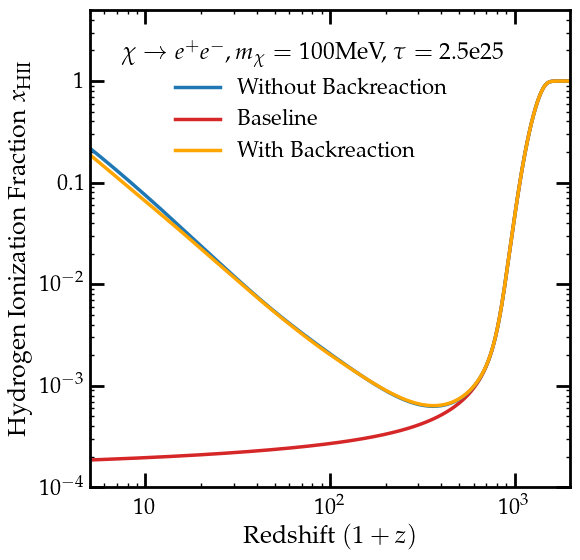

In [525]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('Hydrogen Ionization Fraction $x_\mathrm{HII}$')

plt.axis([5, 2e3, 1e-4, 5])
#plt.axvline(7, color='gray', linestyle='--', alpha=0.3)

# plt.plot(idl_redshift, data[-1][0][0][:,0], label='DH')
plot_noBR, = plt.plot(rs_vec, baseline[:,1], label='Baseline', color='C3')
plot_BR, = plt.plot(rs_vec, no_br[:,1], label='Without Backreaction', color='C0')
plot_std, = plt.plot(br_data['rs'], br_data['x'][:,0], label='With Backreaction', color='orange')

legend = plt.legend(handles=[plot_BR, plot_noBR, plot_std], loc=0, 
#            borderaxespad=0, 
           frameon=False, title='$\chi \\rightarrow e^+e^-, m_\chi = 100$MeV, $\\tau=2.5$e$25$')
legend.get_title().set_fontsize('17')

plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Draft/plots/Example14_1604_comparison_xe.pdf')

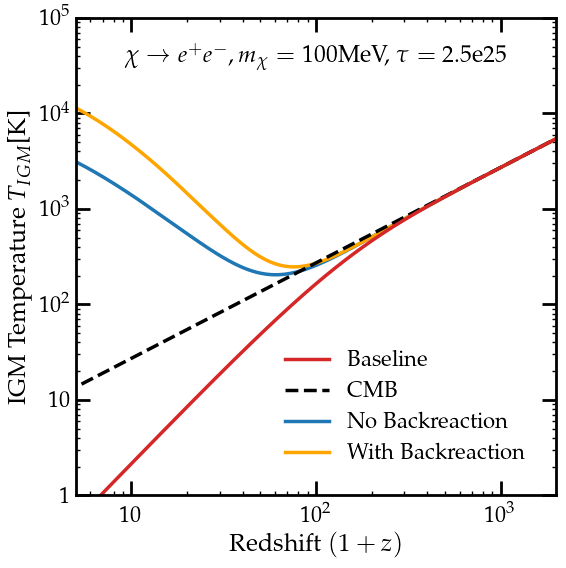

In [536]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('IGM Temperature $T_{IGM}$[K]')

plt.axis([5, 2e3, 1, 1e5])
#plt.axvline(5.8, color='gray', linestyle='--', alpha=0.3)

# plt.plot(idl_redshift, data[-1][0][0][:,0], label='DH')
plot_noBR, = plt.plot(rs_vec, no_br[:,0]/phys.kB, label='No Backreaction', color='C0')
plot_BR, = plt.plot(br_data['rs'], T_br, label='With Backreaction', color='orange')
plot_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, label='CMB', color='k', linestyle='--')
plot_std, = plt.plot(rs_vec, baseline[:,0]/phys.kB, label='Baseline', color='C3')

# legend = plt.legend(handles=[plot_noBR, plot_BR, plot_std, plot_CMB], loc=9,

plt.text(0.1, 0.9, r'$\chi \rightarrow e^+e^-, m_\chi = 100$MeV, $\tau=2.5$e$25$', fontsize=17, transform=ax.transAxes) 


legend = plt.legend(handles=[plot_std, plot_CMB, plot_noBR, plot_BR], loc=4,
#            borderaxespad=0, 
           frameon=False)#, title='$\chi \\rightarrow e^+e^-, m_\chi = 100$MeV, $\\tau=2.5$e$25$')
legend.get_title().set_fontsize('16')

plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Draft/plots/Example14_1604_comparison_T.pdf')
# plt.savefig('/Users/'+user+'/Desktop/Example14_1604_comparison_T.png')

# Calculate With and Without back-reaction

Now we perform the same calculation, except now over a grid of energy injections.  We first specify these energies, then we define the function `get_T` to easily calculate $T_m$ for a given mass and injection model with and without backreaction.

In [197]:
log10_Einj_arr = np.arange(4.01, 12.51, 0.25)

When computing s-wave annihilation models, we must remember that structure formation now boosts the annihilation rate at late times. We can load one of DarkHistory's default structure formation boost factors that can be obtained using the function [*physics.struct_boost_func*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics/darkhistory.physics.struct_boost_func.html). The first thing we need to do is obtain the function that returns the boost: 

In [198]:
struct_boost_einasto_subs = phys.struct_boost_func('einasto_with_subs')

In [660]:
%autoreload

def get_T(mDM, DM_process, br, pri):
    """Gets the temperature history, decays.
    
    Parameters
    ----------
    mDM : float
        The mass of the dark matter in eV. 
    tau : float
        The decay lifetime in s. 
    br : bool
        Whether to use backreaction or not. 
    pri : {'elec', 'phot'}
        The primary particles that DM decays to. 
        
    Returns
    --------
    float
        The temperature history in K. 
    
    """
    
    if pri == 'elec':
        pri_str = 'elec_delta'
        cf = 1
        param = xsec_bound_elec_CMB(mDM, DM_process)
        rs_vec = 3000*np.exp(-.012*np.arange(532))
    if pri == 'phot':
        pri_str = 'phot_delta'
        cf = 1
        param = xsec_bound_phot_CMB(mDM, DM_process)
        rs_vec = 3000*np.exp(-.004*np.arange(1595))
        
    if br:
        result = main.evolve(
            primary=pri_str,
            DM_process=DM_process, mDM=mDM, lifetime=param, sigmav = param,
            start_rs = 3000, end_rs=5.1,
            coarsen_factor=cf, backreaction=True,
            struct_boost = phys.struct_boost_func('einasto_with_subs')
        )
        
        return result['Tm']/phys.kB
    
    else:
        result = get_history(
            rs_vec, baseline_f = True,
            inj_particle = pri, DM_process = DM_process,
            mDM=mDM, lifetime = param, sigmav = param
        )
        
        return result/phys.kB

We now loop over all injection energy and calculate $T_m$ for decay or annihilation into photons or $e^+e^-$.

In [287]:
Tm_no_br = np.array([None for m in log10_Einj_arr])
Tm_br = np.zeros_like(Tm_no_br)

In [288]:
%autoreload
for i, log10Einj in enumerate(tqdm(log10_Einj_arr)):
    
    Einj = 10**log10Einj
    print('****** log10(mDM): ', log10Einj, ' ******')
    

    Tm_no_br[i] = {'phot_decay': get_T(2*Einj, 'decay', br=False, pri='phot'),
                   'phot_swave': get_T(Einj, 'swave', br=False, pri='phot'),
                    'elec_swave': get_T(Einj+phys.me, 'swave', br=False, pri='elec')
                  }

print('###### Calculation Complete! ######')

****** log10(mDM):  4.01  ******
****** log10(mDM):  4.26  ******
****** log10(mDM):  4.51  ******
****** log10(mDM):  4.76  ******
****** log10(mDM):  5.01  ******
****** log10(mDM):  5.26  ******
****** log10(mDM):  5.51  ******
****** log10(mDM):  5.76  ******
****** log10(mDM):  6.01  ******
****** log10(mDM):  6.26  ******
****** log10(mDM):  6.51  ******
****** log10(mDM):  6.76  ******
****** log10(mDM):  7.01  ******
-7.082035448483861e-07
****** log10(mDM):  7.26  ******
****** log10(mDM):  7.51  ******
****** log10(mDM):  7.76  ******
****** log10(mDM):  8.01  ******
****** log10(mDM):  8.26  ******
****** log10(mDM):  8.51  ******
****** log10(mDM):  8.76  ******
****** log10(mDM):  9.01  ******
****** log10(mDM):  9.26  ******
****** log10(mDM):  9.51  ******
****** log10(mDM):  9.76  ******
****** log10(mDM):  10.01  ******
****** log10(mDM):  10.26  ******
****** log10(mDM):  10.51  ******
****** log10(mDM):  10.76  ******
****** log10(mDM):  11.01  ******
****** log10(mD

We must treat the decay to  $e^+e^-$ because the $m_\chi$ values for which we have $\tau_\text{min}$ are different than any of the other cases.

In [289]:
log10_Einj_elec_decay_arr = np.arange(5.01, 12.51, 0.25)
Tm_elec_decay_no_br = np.array([None for m in log10_Einj_arr])
Tm_elec_decay_br = np.zeros_like(Tm_elec_decay_no_br)

In [290]:
%autoreload
for i, log10Einj in enumerate(tqdm(log10_Einj_elec_decay_arr)):
    
    Einj = 10**log10Einj
    print('****** log10(mDM): ', log10Einj, ' ******')
    

    Tm_elec_decay_no_br[i] = get_T(2*Einj+2*phys.me, 'decay', br=False, pri='elec')

print('###### Calculation Complete! ######')

****** log10(mDM):  5.01  ******
****** log10(mDM):  5.26  ******
****** log10(mDM):  5.51  ******
****** log10(mDM):  5.76  ******
****** log10(mDM):  6.01  ******
****** log10(mDM):  6.26  ******
****** log10(mDM):  6.51  ******
****** log10(mDM):  6.76  ******
****** log10(mDM):  7.01  ******
****** log10(mDM):  7.26  ******
****** log10(mDM):  7.51  ******
****** log10(mDM):  7.76  ******
****** log10(mDM):  8.01  ******
****** log10(mDM):  8.26  ******
****** log10(mDM):  8.51  ******
****** log10(mDM):  8.76  ******
****** log10(mDM):  9.01  ******
****** log10(mDM):  9.26  ******
****** log10(mDM):  9.51  ******
****** log10(mDM):  9.76  ******
****** log10(mDM):  10.01  ******
****** log10(mDM):  10.26  ******
****** log10(mDM):  10.51  ******
****** log10(mDM):  10.76  ******
****** log10(mDM):  11.01  ******
****** log10(mDM):  11.26  ******
****** log10(mDM):  11.51  ******
****** log10(mDM):  11.76  ******
****** log10(mDM):  12.01  ******
****** log10(mDM):  12.26  ******


And then we calculate with back-reaction

In [293]:
%autoreload
for i, log10Einj in enumerate(tqdm(log10_Einj_arr)):
    
    Einj = 10**log10Einj
    print('****** log10(mDM): ', log10Einj, ' ******')
    
    Tm_br[i] = {'phot_decay': get_T(2*Einj, 'decay', br=True, pri='phot'),
                   'phot_swave': get_T(Einj, 'swave', br=True, pri='phot'),
                    'elec_swave': get_T(Einj+phys.me, 'swave', br=True, pri='elec')
                  }

print('###### Calculation Complete! ######')

****** log10(mDM):  4.01  ******


****** log10(mDM):  4.26  ******


****** log10(mDM):  4.51  ******


****** log10(mDM):  4.76  ******


****** log10(mDM):  5.01  ******


****** log10(mDM):  5.26  ******


****** log10(mDM):  5.51  ******


****** log10(mDM):  5.76  ******


****** log10(mDM):  6.01  ******


****** log10(mDM):  6.26  ******


****** log10(mDM):  6.51  ******


****** log10(mDM):  6.76  ******


****** log10(mDM):  7.01  ******


****** log10(mDM):  7.26  ******


****** log10(mDM):  7.51  ******


****** log10(mDM):  7.76  ******


****** log10(mDM):  8.01  ******


****** log10(mDM):  8.26  ******


****** log10(mDM):  8.51  ******


****** log10(mDM):  8.76  ******


****** log10(mDM):  9.01  ******


****** log10(mDM):  9.26  ******


****** log10(mDM):  9.51  ******


****** log10(mDM):  9.76  ******


****** log10(mDM):  10.01  ******


****** log10(mDM):  10.26  ******


****** log10(mDM):  10.51  ******


****** log10(mDM):  10.76  ******


****** log10(mDM):  11.01  ******


****** log10(mDM):  11.26  ******


****** log10(mDM):  11.51  ******


****** log10(mDM):  11.76  ******


****** log10(mDM):  12.01  ******


****** log10(mDM):  12.26  ******


###### Calculation Complete! ######


In [661]:
%autoreload
for i, log10Einj in enumerate(tqdm(log10_Einj_elec_decay_arr)):
    
    Einj = 10**log10Einj
    print('****** log10(mDM): ', log10Einj, ' ******')
    

    Tm_elec_decay_br[i] = get_T(2*Einj+2*phys.me, 'decay', br=True, pri='elec')

print('###### Calculation Complete! ######')

****** log10(mDM):  5.01  ******
****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


TypeError: weight must be an ndarray or Spectrum.

## Heat Plots of the Effects of Backreaction

In [498]:
import pickle

In [587]:
# pickle.dump(Tm_no_br,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_no_br.p','wb'))
# pickle.dump(Tm_br,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_br.p','wb'))
# pickle.dump(Tm_elec_decay_no_br,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_elec_decay_no_br.p','wb'))
# pickle.dump(Tm_elec_decay_br,open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_elec_decay_br.p','wb'))

Tm_no_br = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_no_br.p','rb'))
Tm_br = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_br.p','rb'))
Tm_elec_decay_no_br = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_elec_decay_no_br.p','rb'))
Tm_elec_decay_br = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/Gregs_Checks/Tm_elec_decay_br.p','rb'))

Text(0.5, 0, 'Dark Matter Mass $m_\\chi$ [eV]')

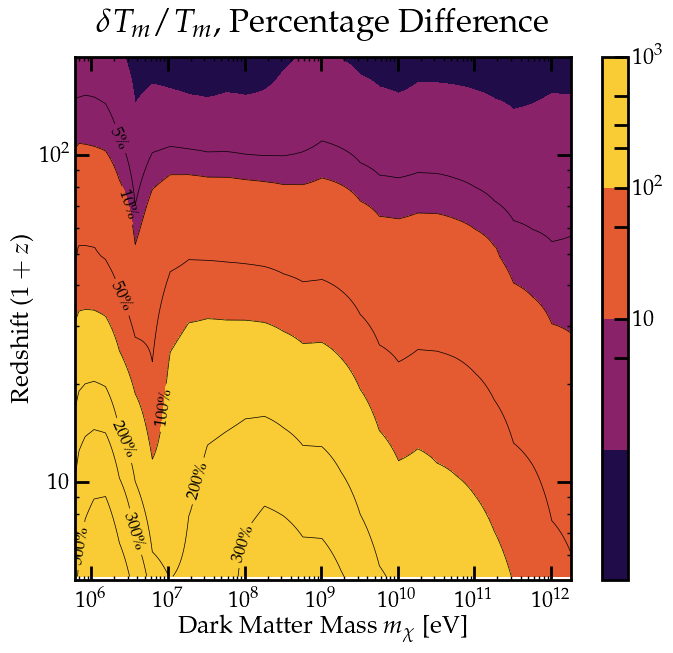

In [589]:
user = 'gregoryridgway'
inj_part = 'elec'
inj_type = 'swave'

log10_E = log10_Einj_arr
if inj_part == 'elec':
    mass = phys.me
else:
    mass = 0

if inj_part == 'phot':
    cf=4
    diff_list = np.array([Tm_br[k][inj_part+'_'+inj_type]/Tm_no_br[k][inj_part+'_'+inj_type][:,0]-1 for k in np.arange(34)])
else:
    if inj_type == 'elec':
        diff_list = np.array([Tm_br[k][inj_part+'_'+inj_type]/Tm_no_br[k][inj_part+'_'+inj_type][:,0]-1 for k in np.arange(34)])
    else:
        log10_E = log10_Einj_elec_decay_arr
        diff_list = np.array([Tm_elec_decay_br[k]/Tm_elec_decay_no_br[k][:,0]-1 for k in np.arange(30)])    
    cf=12
    
if inj_type == 'decay':
    log10m = np.log10(2*mass + 2*10**log10_E)
else:
    log10m = np.log10(mass + 10**log10_E)

rs_list = np.exp(np.arange(np.log(2e2), np.log(5.1), step=-0.001*cf))
length=len(rs_list)

plt.figure(figsize=(8,6.8))

ax = plt.gca()
ax.loglog()

if inj_part == 'phot':
    if inj_type == 'decay':
        levels = [5, 10, 50, 100, 200, 300, 500, 1000]
        labels = { 
            5:r'$5$\%', 
            10:r'$10$\%', 
            50:r'$50$\%',
            100:r'$100$\%',
            200:r'$200$\%',
            300:r'$300$\%',
            500:r'$500$\%',
            1000:r'$1000$\%'
        }
    else:
        levels = [.1, .5, 1, 2, 5, 10, 15]
        labels = { 
            .1: r'.1\%',
            .5:r'.5\%', 
            1:r'1\%',
            2:r'2\%',
            5:r'5\%',
            10:r'10\%',
            15:r'15\%',
        }
else:
    levels = [5, 10, 50, 100, 200, 300, 500, 1000]
    labels = { 
        5:r'$5$\%', 
        10:r'$10$\%', 
        50:r'$50$\%',
        100:r'$100$\%',
        200:r'$200$\%',
        300:r'$300$\%',
        500:r'$500$\%',
        1000:r'$1000$\%'
    }
   
plt_heating = plt.contour(
    10**log10m, rs_list, 
    np.transpose(np.abs(diff_list)*100)[-length:],
    levels=levels,
    linewidths=0.5,
    colors='k'
)
plt.axis([10**log10m[0], 10**log10m[-1], 5, 2e2])

plt.clabel(
    plt_heating, inline=True, fontsize=12, rightside_up=True,
    fmt=labels
)

cntr1 = ax.contourf(10**log10m, 
                    rs_list, 
                    np.transpose(np.abs(diff_list)*100)[-length:], 
                    100, 
                    norm=matplotlib.colors.LogNorm(),
                    cmap=matplotlib.cm.inferno)

cbar = plt.colorbar(cntr1, ax=ax, ticks = levels)
cbar.ax.set_xticklabels(str(levels))

# plt.colorbar(cntr1, ax=ax)

# plt.title(r'\bf{$\delta_{T_m}$}')
plt.title(r'$\delta T_m/T_m$, Percentage Difference')
plt.ylabel(r'Redshift ($1+z$)')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')

# plt.savefig('/Users/'+user+'/Desktop/DM/Papers/plots/backReact_'+inj_part+'_residuals_'+inj_type+'_v2.pdf')
# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/backReact_phot_residuals_v2.pdf')

# Debug

In [591]:
tmp = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_phot/f_phot_swave_notCrossCheck.p','rb'))

In [626]:
rs_vec = f_DH_data[0]['rs']
def get_fcontour(f_input, inj_type, inj_particle, channel):
    f_for_plot = f_input.copy()
    eng = 10**log10eng
    coarsen_factor=round(6398/f_for_plot.shape[-1])

    ind = {'H_ion' : 0, 'He_ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H_ion' : 'H_{ion}', 'He_ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'
    
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 4.01, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    else:
        if inj_particle == 'phot':
            levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 50, 200])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1, 5, 10,100])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 100, 500])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 100])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 500])
        elif inj_particle == 'elec':
            levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 1, 10, 100, 1000, 10000])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 2e-3, 1e-2, 1e-1, 10, 50, 1000])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 2e-1, 1, 10, 100, 1000, 5000])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 10, 100, 1000, 10000])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 10, 100, 1000, 10000])
                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,rs_vec,
                     np.transpose(f_for_plot[:,:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.inferno)
#                      cmap=matplotlib.cm.RdBu_r)
    
    ax.contour(eng,rs_vec,
               np.transpose(f_for_plot[:,:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')
    
#     plt.savefig(
#         cwd+'/../../../f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.png'
#     )
#     plt.savefig(
#         '/Users/gridgway/Dropbox (MIT)/Photon Deposition/Draft/plots/f_contour/f'+
#         inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
#     )
    plt.show()

In [672]:
rs_vec = 3000*np.exp(-.001*np.arange(6620))

In [673]:
rs_vec

array([3000.        , 2997.0014995 , 2994.005996  , ...,    4.01231173,
          4.00830143,    4.00429513])

In [773]:
f_DH_data = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                   +'phot/f_phot_decay_notCrossCheck.p','rb')
                  )

In [795]:
tmp1[25][:,0]/f_DH_data[2+25]['f']['low']['H ion'][:6398]

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([       nan, 0.99994608, 1.01305553, ..., 1.00002167, 1.00002184,
       1.00002204])

In [801]:
inj_particle='photon'
inj_str=inj_particle[:4]
inj_type='swave'
struct = True
if struct:
    extra = ''
else:
    extra = '_noStructure'
    
if inj_particle == 'photon':
    coarsen_factor = 1
else:
    coarsen_factor = 1
    
f_DH_data = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/Photon Deposition/idl_comparison/GR_Checks/ih_continuous_'
                   +inj_str+'/f_'+inj_str+'_'+inj_type+'_notCrossCheck'+extra+'.p','rb')
                  )

f_DH_list = np.ones((40,5,round(6620)))*1e-6
for k in np.arange(40):
    f_DH_list[k] = np.array(
    [f_DH_data[k]['f']['low']['H ion']+f_DH_data[k]['f']['high']['H ion'],
     f_DH_data[k]['f']['low']['He ion']+f_DH_data[k]['f']['high']['He ion'],
     f_DH_data[k]['f']['low']['exc']+f_DH_data[k]['f']['high']['exc'],
     f_DH_data[k]['f']['low']['heat']+f_DH_data[k]['f']['high']['heat'],
     f_DH_data[k]['f']['low']['cont']+f_DH_data[k]['f']['high']['cont']]
)

f_DH_list = np.swapaxes(f_DH_list,1,2)
f_DH_list[f_DH_list<=0] = 1e-12

In [802]:
rs_vec = f_DH_data[0]['rs']
def get_fcontour(f_input, inj_type, inj_particle, channel):
    f_for_plot = f_input.copy()
    eng = 10**log10eng
    coarsen_factor=round(6398/f_for_plot.shape[-1])

    ind = {'H_ion' : 0, 'He_ion' : 1, 'exc' : 2, 'heat' : 3, 'cont' : 4}[channel]
    if ind < 2:
        label = {'H_ion' : 'H_{ion}', 'He_ion' : 'He_{ion}'}[channel]
    else:
        label = channel
    title = r'\bf{$f_{'+label+'}$}'
    
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5.01, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    else:
        if inj_particle == 'phot':
            levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 50, 200])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1, 5, 10,100])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 100, 500])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 10, 100])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10, 50, 500])
        elif inj_particle == 'elec':
            levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 1, 10, 100, 1000, 10000])
            if channel is 'He_ion':
                levels = np.array([1e-5, 1e-4, 1e-3, 2e-3, 1e-2, 1e-1, 10, 50, 1000])
            elif channel is 'exc':
                levels = np.array([1e-3, 1e-2, 5e-2, 1e-1, 2e-1, 1, 10, 100, 1000, 5000])
            elif channel is 'heat':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 10, 100, 1000, 10000])
            elif channel is 'cont':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 10, 100, 1000, 10000])
                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,rs_vec,
                     np.transpose(f_for_plot[:,:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.inferno)
#                      cmap=matplotlib.cm.RdBu_r)
    
    ax.contour(eng,rs_vec,
               np.transpose(f_for_plot[:,:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')
    
#     plt.savefig(
#         cwd+'/../../../f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.png'
#     )
#     plt.savefig(
#         '/Users/gridgway/Dropbox (MIT)/Photon Deposition/Draft/plots/f_contour/f'+
#         inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
#     )
    plt.show()

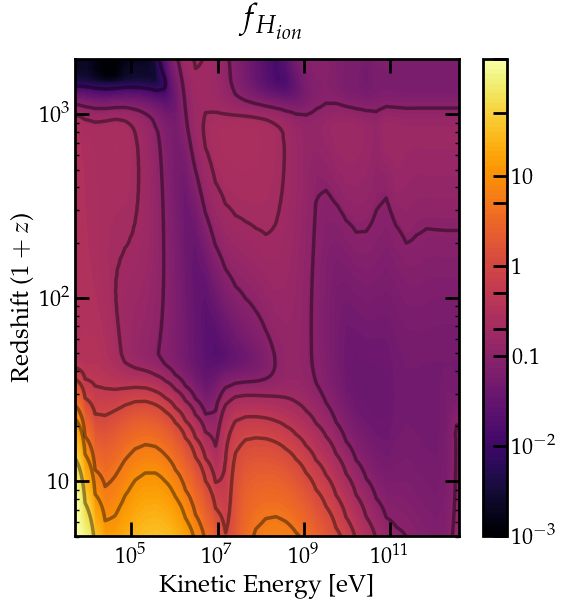

In [803]:
get_fcontour(f_DH_list, inj_type, inj_str, 'H_ion')

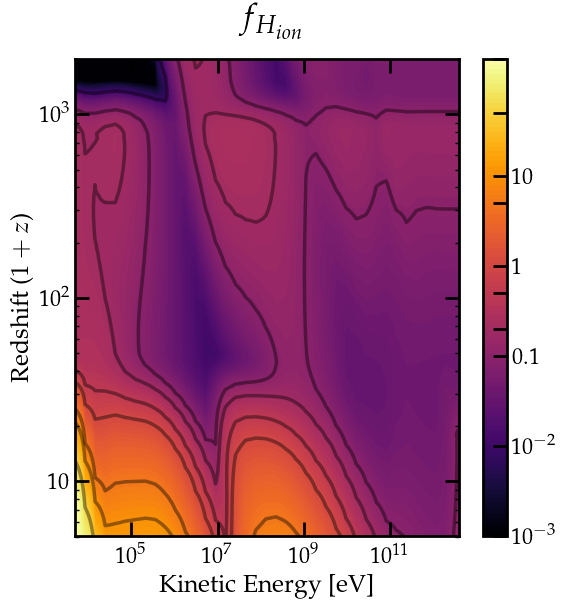

In [800]:
get_fcontour(f_DH_list, inj_type, inj_str, 'H_ion')

In [750]:
tmp = pickle.load(open('/Users/gregoryridgway/Dropbox (MIT)/DH_Paper_Data/Example14_data_phot.p','rb'))

In [710]:
tmp[0][0][-1][0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.33509824e-06,  1.33509824e-06,  1.33509824e-06,
         1.33509824e-02, -7.12838453e-02],
       [ 8.54811924e-06,  2.63774207e-06,  6.66459853e-05,
         2.63774207e-02, -7.08008405e-02],
       ...,
       [ 9.51747877e-04,  5.54524296e-05,  8.41755615e-04,
         4.69176199e-04,  3.71145309e-04],
       [ 9.50762255e-04,  5.53948278e-05,  8.40871876e-04,
         4.68673907e-04,  3.70752983e-04],
       [ 9.49776982e-04,  5.53372462e-05,  8.39988477e-04,
         4.68171825e-04,  3.70360811e-04]])

In [737]:
tmp1 = np.array([tmp[k][0][-1][0] for k in np.arange(len(tmp))])

In [738]:
tmp2 = np.array([tmp[k][1][-1][0] for k in np.arange(len(tmp))])

In [755]:
tmp1[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.33509824e-06,  1.33509824e-06,  1.33509824e-06,
         1.33509824e-02, -7.12838453e-02],
       [ 8.54811924e-06,  2.63774207e-06,  6.66459853e-05,
         2.63774207e-02, -7.08008405e-02],
       ...,
       [ 9.51747877e-04,  5.54524296e-05,  8.41755615e-04,
         4.69176199e-04,  3.71145309e-04],
       [ 9.50762255e-04,  5.53948278e-05,  8.40871876e-04,
         4.68673907e-04,  3.70752983e-04],
       [ 9.49776982e-04,  5.53372462e-05,  8.39988477e-04,
         4.68171825e-04,  3.70360811e-04]])

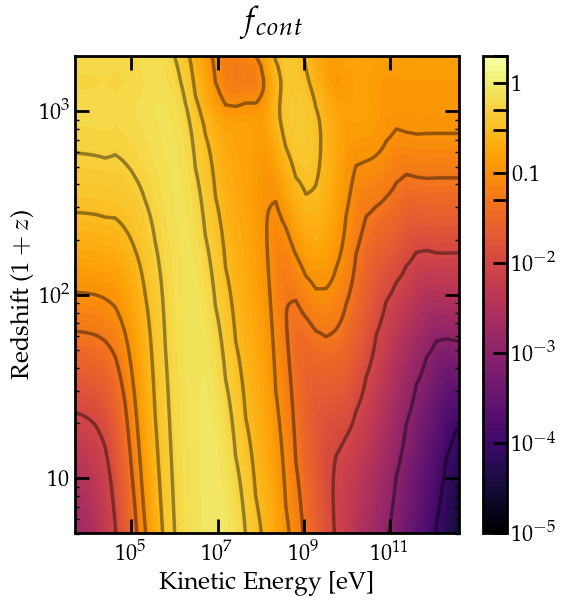

In [648]:
inj_type='decay'
inj_str='elec'
get_fcontour(tmp, inj_type, inj_str, 'cont')

In [641]:
rs_vec = 3000*np.exp(-.001*np.arange(6397))

- make it square (manually make it square, figsize or something)
- One more color at the low end or the redshift
- make this go down to ~20 keV 
- double-check that your functions aren't off by a factor of 2 by comparing to Chih-Liang/Tracy paper
- dark matter mass on the x-axis

- include best new f's overlayed against the old contours from 2016 results (as is).  Turn off color bar, red dashed for 2016 and black for.  But first try just overlaying the red dashed contours.
- make the plot text of the same order as the caption text
- try combining them